# **Checking Auto encoder denosing**

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import math

# Define the denoising autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the pre-trained model
model = DenoisingAutoencoder()
model.load_state_dict(torch.load('denoising_model_16a_1.pth'))
model.eval()

# Define data transformation for inference
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

In [ ]:
import os
from PIL import Image

# Assuming you have already defined the 'transform' variable

clean_path = '*****Path to clean SAR image*****'  # Change this to your folder path
noisy_path = '*****Path to noisy SAR image*****'
# List all files in the folder
file_list = os.listdir(clean_path)

cleanTensor = []
noisyTensor = []
# Process each image in the folder
for file_name in file_list:
    # Construct the full path to the image
    image_path = os.path.join(clean_path, file_name)

    # Load and preprocess the image
    image = Image.open(image_path).convert('L')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Now you can use 'image_tensor' for further processing
    # For example, if you want to print the shape of the tensor:
    cleanTensor.append(image_tensor)
    #print(image_tensor.shape)


file_list = os.listdir(noisy_path)
# Process each image in the folder
for file_name in file_list:
    # Construct the full path to the image
    image_path = os.path.join(noisy_path, file_name)

    # Load and preprocess the image
    image = Image.open(image_path).convert('L')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    noisyTensor.append(image_tensor)
    # Now you can use 'image_tensor' for further processing
    # For example, if you want to print the shape of the tensor:
    #print(image_tensor.shape)



In [ ]:
import math

# Calculate PSNR before denoising
def calculate_psnr(image1, image2):
    mse = ((image1 - image2) ** 2).mean()
    max_pixel_value = 255
    psnr = 20 * math.log10(max_pixel_value) - 10 * math.log10(mse)
    return psnr

psnr_values = []

for clean_img, noisy_img in zip(cleanTensor, noisyTensor):
    # Assuming clean_img and noisy_img are tensors
    clean_img = clean_img.squeeze(0).numpy()  # Convert tensor to numpy array
    noisy_img = noisy_img.squeeze(0).numpy()  # Convert tensor to numpy array

    psnr = calculate_psnr(clean_img, noisy_img)
    psnr_values.append(psnr)

# Calculate the average PSNR value
average_psnr = sum(psnr_values) / len(psnr_values)

print("Average PSNR:", average_psnr)


Average PSNR: 63.51307895684211


In [ ]:
# Perform denoising
denoised_tensor = []
for i in range(len(noisyTensor)):
    with torch.no_grad():
        denoised_tensor.append(model(noisyTensor[i]))



In [ ]:
psnr_after = []

for clean_img, denoised_img in zip(cleanTensor, denoised_tensor):
    # Assuming clean_img and noisy_img are tensors
    clean_img = clean_img.squeeze(0).numpy()  # Convert tensor to numpy array
    denoised_img = denoised_img.squeeze(0).numpy()  # Convert tensor to numpy array

    psnr = calculate_psnr(clean_img, denoised_img)
    psnr_after.append(psnr)

# Calculate the average PSNR value
average_psnr_after = sum(psnr_after) / len(psnr_after)

print("Average PSNR:", average_psnr_after)

Average PSNR: 70.03527720360094


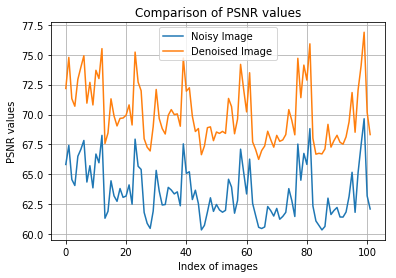

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your arrays)
# x_values = [i for i in range(60,80)]
array1 = psnr_values
array2 = psnr_after

# Plot the values of both arrays on the same graph
plt.plot(array1, label='Noisy Image')
plt.plot(array2, label='Denoised Image')

# Add labels and legend
plt.xlabel('Index of images')
plt.ylabel('PSNR values')
plt.title('Comparison of PSNR values')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid for better visualization
plt.savefig('comparison_plot.png', dpi=300)
plt.show()


# **Comparison with Lee Filter**

In [ ]:
import torch
import torch.nn.functional as F

def lee_filter(noisyTensor, size):
    # Calculate mean and squared mean for noisy image
    noisy_img_mean = F.avg_pool2d(noisyTensor, kernel_size=size, stride=1, padding=size//2)
    noisy_img_sqr_mean = F.avg_pool2d(noisyTensor ** 2, kernel_size=size, stride=1, padding=size//2)

    # Calculate variance for noisy image
    noisy_img_variance = noisy_img_sqr_mean - noisy_img_mean ** 2

    # Calculate overall variance
    overall_variance = torch.var(noisyTensor)

    # Calculate weights
    noisy_img_weights = noisy_img_variance / (noisy_img_variance + overall_variance)

    # Calculate filtered output
    noisy_img_output = noisy_img_mean + noisy_img_weights * (noisyTensor - noisy_img_mean)

    return noisy_img_output



In [ ]:
LeeFilter_tensor = []
for i in range(len(noisyTensor)):
    LeeFilter_tensor.append(lee_filter(noisyTensor[i], size=3))

In [ ]:
psnr_after_lee = []

for clean_img, denoised_img in zip(cleanTensor, LeeFilter_tensor):
    # Assuming clean_img and noisy_img are tensors
    clean_img = clean_img.squeeze(0).numpy()  # Convert tensor to numpy array
    denoised_img = denoised_img.squeeze(0).numpy()  # Convert tensor to numpy array

    psnr = calculate_psnr(clean_img, denoised_img)
    psnr_after_lee.append(psnr)

# Calculate the average PSNR value
average_psnr_after_lee = sum(psnr_after_lee) / len(psnr_after_lee)

print("Average PSNR:", average_psnr_after_lee)

Average PSNR: 67.84951945366421


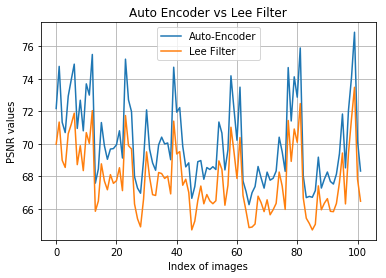

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your arrays)
# x_values = [i for i in range(60,80)]
array1 = psnr_after
array2 = psnr_after_lee

# Plot the values of both arrays on the same graph
plt.plot(array1, label='Auto-Encoder')
plt.plot(array2, label='Lee Filter')

# Add labels and legend
plt.xlabel('Index of images')
plt.ylabel('PSNR values')
plt.title('Auto Encoder vs Lee Filter')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid for better visualization
plt.savefig('Auto_encoder_Lee_filter.png', dpi=300)
plt.show()

# **Comparison with Frost Filter**

In [ ]:
import torch
import torch.nn.functional as F

def frost_filter(noisyTensor, size, alpha):
    # Calculate local mean
    local_mean = F.avg_pool2d(noisyTensor, kernel_size=size, stride=1, padding=size//2)

    # Calculate local variance
    local_var = F.avg_pool2d(noisyTensor ** 2, kernel_size=size, stride=1, padding=size//2) - local_mean ** 2

    # Calculate local alpha
    local_alpha = alpha * local_var

    # Calculate local beta
    local_beta = 1 - local_alpha

    # Calculate filtered output
    denoised_tensor = local_alpha * noisyTensor + local_beta * local_mean

    return denoised_tensor


In [ ]:
FrostFilter_tensor = []
for i in range(len(noisyTensor)):
    FrostFilter_tensor.append(frost_filter(noisyTensor[i], size=3, alpha=0.5))

In [ ]:
FrostFilter_tensor2 = []
for i in range(len(noisyTensor)):
    FrostFilter_tensor2.append(frost_filter(noisyTensor[i], size=3, alpha=0.1))

In [ ]:
FrostFilter_tensor3 = []
for i in range(len(noisyTensor)):
    FrostFilter_tensor3.append(frost_filter(noisyTensor[i], size=3, alpha=1))

In [ ]:
psnr_after_frost = []

for clean_img, denoised_img in zip(cleanTensor, FrostFilter_tensor):
    # Assuming clean_img and noisy_img are tensors
    clean_img = clean_img.squeeze(0).numpy()  # Convert tensor to numpy array
    denoised_img = denoised_img.squeeze(0).numpy()  # Convert tensor to numpy array

    psnr = calculate_psnr(clean_img, denoised_img)
    psnr_after_frost.append(psnr)

# Calculate the average PSNR value
average_psnr_after_frost = sum(psnr_after_frost) / len(psnr_after_frost)

print("Average PSNR:", average_psnr_after_frost)

Average PSNR: 70.02031629483707


In [ ]:
psnr_after_frost2 = []

for clean_img, denoised_img in zip(cleanTensor, FrostFilter_tensor2):
    # Assuming clean_img and noisy_img are tensors
    clean_img = clean_img.squeeze(0).numpy()  # Convert tensor to numpy array
    denoised_img = denoised_img.squeeze(0).numpy()  # Convert tensor to numpy array

    psnr = calculate_psnr(clean_img, denoised_img)
    psnr_after_frost2.append(psnr)

# Calculate the average PSNR value
average_psnr_after_frost2 = sum(psnr_after_frost2) / len(psnr_after_frost2)

print("Average PSNR:", average_psnr_after_frost2)

Average PSNR: 69.93486045366673


In [ ]:
psnr_after_frost3 = []

for clean_img, denoised_img in zip(cleanTensor, FrostFilter_tensor3):
    # Assuming clean_img and noisy_img are tensors
    clean_img = clean_img.squeeze(0).numpy()  # Convert tensor to numpy array
    denoised_img = denoised_img.squeeze(0).numpy()  # Convert tensor to numpy array

    psnr = calculate_psnr(clean_img, denoised_img)
    psnr_after_frost3.append(psnr)

# Calculate the average PSNR value
average_psnr_after_frost3 = sum(psnr_after_frost3) / len(psnr_after_frost3)

print("Average PSNR:", average_psnr_after_frost3)

Average PSNR: 70.08949377678869


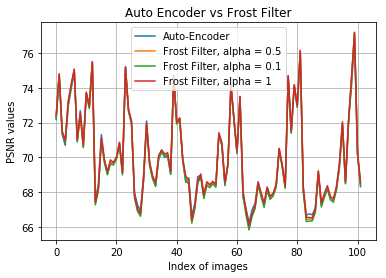

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your arrays)
# x_values = [i for i in range(60,80)]
array1 = psnr_after
array2 = psnr_after_frost
array3 = psnr_after_frost2
array4 = psnr_after_frost3
#array3 = psnr_after_lee

# Plot the values of both arrays on the same graph
plt.plot(array1, label='Auto-Encoder')
plt.plot(array2, label='Frost Filter, alpha = 0.5')
plt.plot(array3, label='Frost Filter, alpha = 0.1')
plt.plot(array4, label='Frost Filter, alpha = 1')
#plt.plot(array3, label='Lee Filter')

# Add labels and legend
plt.xlabel('Index of images')
plt.ylabel('PSNR values')
plt.title('Auto Encoder vs Frost Filter')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid for better visualization
plt.savefig('Auto_encoder_Frost_filter_alpha.png', dpi=300)
plt.show()